In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install Sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 209 kB 5.3 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import json
import pickle
import string
import re

import nltk
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

import tensorflow
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
intents_file = open('/content/drive/MyDrive/Capstone Project/Colab Notebook/datasets/mentalhealth_intent_update2_new.json').read()
open_intents = json.loads(intents_file)

open_intents

{'intents': [{'context': [''],
   'patterns': ['Halo',
    'Halo Booboo',
    'Hai',
    'Selamat pagi',
    'Selamat siang',
    'Selamat sore',
    'Selamat malam',
    'Apa kabar?',
    'Hai, mau tanya dong',
    'Halo, saya mau bertanya',
    'Aku mau curhat'],
   'responses': ['Halo! Namaku Booboo. Aku bersedia menjadi teman bicaramu, juga bisa membantumu untuk mengetahui informasi dasar seputar kesehatan mental. Apa yang ingin kamu tanyakan atau sampaikan?'],
   'tag': 'salam'},
  {'context': [''],
   'patterns': ['Bagaimana cara mengubah perasaan saya tidak berharga bagi semua orang?',
    'Saya nyaris tidak tidur dan tidak melakukan apa-apa selain memikirkan bagaimana saya tidak berharga dan bagaimana saya seharusnya tidak berada di sini',
    'Saya memiliki banyak masalah',
    'Saya memiliki sejarah panjang depresi dan mulai memiliki kecemasan',
    'Saya menghadapi depresi dan kecemasan yang parah',
    'Bagaimana cara mengatasi kecemasan dan depresi ini?',
    'Saya merasa 

In [ ]:
#convert to dataframes
 
def convert_to_dataframes(feat_1, feat_2, is_pattern):
  is_pattern = is_pattern
  df = pd.DataFrame(columns=[feat_1, feat_2])
  for intent in open_intents['intents']:
    if is_pattern:
      for pattern in intent['patterns']:
        w = pattern
        df_to_append = pd.Series([w, intent['tag']], index = df.columns)
        df = df.append(df_to_append, ignore_index=True)
    else:
      for response in intent['responses']:
        w = response
        df_to_append = pd.Series([w, intent['tag']], index = df.columns)
        df = df.append(df_to_append, ignore_index=True)
  return df

In [ ]:
df1 = convert_to_dataframes('pertanyaan', 'label', True)

df1

,pertanyaan,label
0,Halo,salam
1,Halo Booboo,salam
2,Hai,salam
3,Selamat pagi,salam
4,Selamat siang,salam
...,...,...
164,Dadah!,bye_thanks
165,Selamat tinggal,bye_thanks
166,"Makasih ya, ini sangat membantu",bye_thanks
167,"Terima kasih, aku merasa lebih baik sekarang",bye_thanks


In [ ]:
df2 = convert_to_dataframes('jawaban', 'label', False)

df2

,jawaban,label
0,Halo! Namaku Booboo. Aku bersedia menjadi tema...,salam
1,Sepertinya kamu mungkin berjuang dengan depres...,depresi
2,"Oh, aku ikut sedih mendengarnya. Aku mengerti,...",keluarga
3,Pasti berat sekali rasanya memiliki masalah ya...,hubungan
4,"Apa yang kamu alami adalah kecemasan, sebenarn...",kecemasan
5,Anda bisa membuka website rumah sakit yang ing...,konseling_fundamental
6,Sepertinya kamu memiliki persepsi bahwa orang ...,harga_diri
7,Sepertinya Anda mengalami trauma. Ada banyak j...,trauma
8,Kami menyarankan mereka yang memiliki gejala b...,cari_bantuan
9,"Jika ini benar-benar menghambat kehidupanmu, m...",perubahan_perilaku


In [ ]:
#number of patterns

df1.label.value_counts(sort=True)

keluarga                 21
kecemasan                16
depresi                  13
manajemen_emosi          13
salam                    11
hubungan                 11
trauma                   11
perubahan_perilaku       10
bye_thanks               10
harga_diri                9
bunuh_diri                9
definisi                  8
gangguan_tidur            8
cari_bantuan              7
penyalahgunaan_zat        7
konseling_fundamental     5
Name: label, dtype: int64

In [ ]:
#data preprocessing

words = []
classes = []
vocabs = []

stopwords_indonesia = stopwords.words('indonesian')
factory = StemmerFactory()
stemmer = factory.create_stemmer()

for intent in open_intents['intents']:
    for pattern in intent['patterns']:
        tokens = pattern.lower()
        re_punc = re.compile('[%s]' % re.escape(string.punctuation))
        tokens = re_punc.sub('', pattern)
        tokens = nltk.word_tokenize(pattern)
        words.extend(tokens)

        #remove stopwords
        words = [w for w in words if not w in stopwords_indonesia]
        words = [stemmer.stem(w) for w in words]

        #add data in the corpus
        vocabs.append((tokens, intent['tag']))

        #add to classes list
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

print(vocabs)

[(['Halo'], 'salam'), (['Halo', 'Booboo'], 'salam'), (['Hai'], 'salam'), (['Selamat', 'pagi'], 'salam'), (['Selamat', 'siang'], 'salam'), (['Selamat', 'sore'], 'salam'), (['Selamat', 'malam'], 'salam'), (['Apa', 'kabar', '?'], 'salam'), (['Hai', ',', 'mau', 'tanya', 'dong'], 'salam'), (['Halo', ',', 'saya', 'mau', 'bertanya'], 'salam'), (['Aku', 'mau', 'curhat'], 'salam'), (['Bagaimana', 'cara', 'mengubah', 'perasaan', 'saya', 'tidak', 'berharga', 'bagi', 'semua', 'orang', '?'], 'depresi'), (['Saya', 'nyaris', 'tidak', 'tidur', 'dan', 'tidak', 'melakukan', 'apa-apa', 'selain', 'memikirkan', 'bagaimana', 'saya', 'tidak', 'berharga', 'dan', 'bagaimana', 'saya', 'seharusnya', 'tidak', 'berada', 'di', 'sini'], 'depresi'), (['Saya', 'memiliki', 'banyak', 'masalah'], 'depresi'), (['Saya', 'memiliki', 'sejarah', 'panjang', 'depresi', 'dan', 'mulai', 'memiliki', 'kecemasan'], 'depresi'), (['Saya', 'menghadapi', 'depresi', 'dan', 'kecemasan', 'yang', 'parah'], 'depresi'), (['Bagaimana', 'cara',

In [ ]:
#sorted word and classes
words = sorted(list(set(words)))
classes = sorted(list(set(classes)))

#save to pickle
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))

In [ ]:
#create the training data
training_data = []

#create empty array for the output
empty_array = [0] * len(classes)

#training set, bag of words for every sentence, and lemmatize
for voc in vocabs:
    bag_words = []
    word_patterns = voc[0]
    word_patterns = [stemmer.stem(word.lower()) for word in word_patterns]

    #create the bag of words array with 1, if word is found in current pattern
    for word in words:
        bag_words.append(1) if word in word_patterns else bag_words.append(0)

    #output is a '0' for each tag and '1' for current tag (for each pattern)
    output_row = list(empty_array)
    output_row[classes.index(voc[1])] = 1
    training_data.append([bag_words, output_row])

#shuffle the features and make numpy array
random.shuffle(training_data)
train = np.array(training_data)

#create training list (X - patterns, y - intents)
train_X = list(train[:,0])
train_y = list(train[:,1])

print("Training data succesfully created!")

Training data succesfully created!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
#create model

model = Sequential()
model.add(Dense(128, input_shape=(len(train_X[0]),), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               30592     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 16)                1040      
                                                                 
Total params: 39,888
Trainable params: 39,888
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#training and save the model 
history = model.fit(np.array(train_X), np.array(train_y), epochs=200, batch_size=5, verbose=1)
model.save("chatbot_model_new.h5", history)
print("Model successfully created!")

Epoch 1/200
34/34 [==============================] - 1s 2ms/step - loss: 2.7815 - accuracy: 0.0651
Epoch 2/200
34/34 [==============================] - 0s 2ms/step - loss: 2.7189 - accuracy: 0.1124
Epoch 3/200
34/34 [==============================] - 0s 2ms/step - loss: 2.6647 - accuracy: 0.1302
Epoch 4/200
34/34 [==============================] - 0s 2ms/step - loss: 2.5902 - accuracy: 0.1893
Epoch 5/200
34/34 [==============================] - 0s 2ms/step - loss: 2.5545 - accuracy: 0.1716
Epoch 6/200
34/34 [==============================] - 0s 2ms/step - loss: 2.4355 - accuracy: 0.2012
Epoch 7/200
34/34 [==============================] - 0s 3ms/step - loss: 2.3491 - accuracy: 0.2544
Epoch 8/200
34/34 [==============================] - 0s 2ms/step - loss: 2.2400 - accuracy: 0.3195
Epoch 9/200
34/34 [==============================] - 0s 2ms/step - loss: 2.1758 - accuracy: 0.3550
Epoch 10/200
34/34 [==============================] - 0s 2ms/step - loss: 2.0074 - accuracy: 0.4201
Epoch 11/

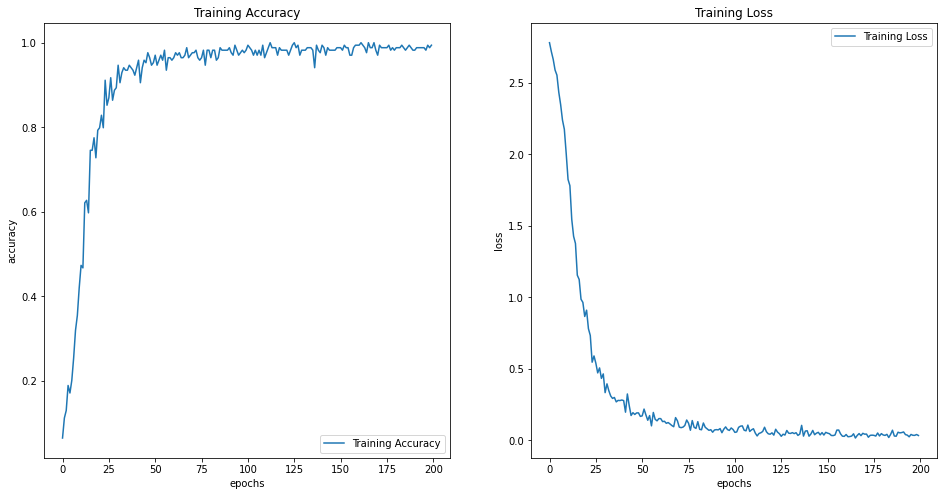

In [ ]:
#learning curves 

acc = history.history['accuracy']
loss=history.history['loss']

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
#convert model to tflite

model = tensorflow.keras.models.load_model("chatbot_model_new.h5")
converter = tensorflow.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("chatbot_model_new.tflite", "wb").write(tflite_model)

print("Model succesfully converted!")

INFO:tensorflow:Assets written to: /tmp/tmpzhyq0tsk/assets


Model succesfully converted!
